In [14]:
import pandas as pd  # pandas library for dataframe
import numpy as np   # numpy library for number
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import date

In [3]:
original_df = pd.read_csv(f"UK_sales_for_ML.csv",encoding="latin1")

In [4]:
raw_df = original_df.copy()

In [5]:
raw_df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,UnitPrice_log,Quantity_log,Revenue,Year,Month,Day,day_of_week,day_name,quarter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1.266948,1.94591,15,2010,12,1,2,Wednesday,4


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471726 entries, 0 to 471725
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceNo      471726 non-null  int64  
 1   StockCode      471726 non-null  object 
 2   Description    471726 non-null  object 
 3   Quantity       471726 non-null  int64  
 4   InvoiceDate    471726 non-null  object 
 5   UnitPrice      471726 non-null  float64
 6   CustomerID     471726 non-null  float64
 7   Country        471726 non-null  object 
 8   UnitPrice_log  471726 non-null  float64
 9   Quantity_log   471726 non-null  float64
 10  Revenue        471726 non-null  int64  
 11  Year           471726 non-null  int64  
 12  Month          471726 non-null  int64  
 13  Day            471726 non-null  int64  
 14  day_of_week    471726 non-null  int64  
 15  day_name       471726 non-null  object 
 16  quarter        471726 non-null  int64  
dtypes: float64(4), int64(8), obje

In [6]:
raw_df["InvoiceNo"] = raw_df["InvoiceNo"].astype("int32")
raw_df["CustomerID"] = raw_df["CustomerID"].astype("int16")
raw_df["Quantity"] = raw_df["Quantity"].astype("int16")
raw_df["UnitPrice"] = raw_df["UnitPrice"].astype("float16")
raw_df["Revenue"] = raw_df["Revenue"].astype("int16")
raw_df["quarter"] = raw_df["quarter"].astype("int8")
raw_df["day_of_week"] = raw_df["day_of_week"].astype("int8")
raw_df["Year"] = raw_df["Year"].astype("int16")
raw_df["Month"] = raw_df["Month"].astype("int8")
raw_df["Day"] = raw_df["Day"].astype("int8")

In [11]:
customer_data = raw_df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',     # Number of purchases
    'Quantity': 'sum',          # Total quantity purchased
    'Revenue': 'sum',           # Total revenue generated
    'InvoiceDate': ['min', 'max'],  # First and last purchase dates
}).reset_index()

# Rename columns for clarity
customer_data.columns = ['CustomerID', 'Unique_Invoice', 'Total_Quantity', 'Total_Revenue', 'First_Purchase', 'Last_Purchase']


In [23]:
customer_data["First_Purchase"] = pd.to_datetime(customer_data["First_Purchase"])
customer_data["Last_Purchase"] = pd.to_datetime(customer_data["Last_Purchase"])

In [24]:
# Calculate Recency
customer_data['Recency'] = (pd.to_datetime(date.today()) - customer_data['Last_Purchase']).dt.days
customer_data['Avg_Order_Value'] = customer_data['Total_Revenue'] / customer_data['Unique_Invoice']

# Frequency and Monetary are already included in the aggregated data (Num_Purchases and Total_Revenue)


In [25]:
customer_data

,CustomerID,Unique_Invoice,Total_Quantity,Total_Revenue,First_Purchase,Last_Purchase,Recency,Avg_Order_Value
0,12747,11,1275,4143,2010-12-05 15:38:00,2011-12-07 14:34:00,4681,376.636364
1,12748,218,24366,37037,2010-12-01 12:48:00,2011-12-09 12:20:00,4679,169.894495
2,12749,6,2247,7465,2011-05-10 15:25:00,2011-12-06 10:05:00,4682,1244.166667
3,12820,4,722,916,2011-01-17 12:34:00,2011-12-06 15:12:00,4682,229.000000
4,12821,1,70,90,2011-05-09 15:51:00,2011-05-09 15:51:00,4893,90.000000
...,...,...,...,...,...,...,...,...
3872,18280,6,1560,6407,2011-03-07 09:52:00,2011-03-07 10:15:00,4956,1067.833333
3873,18281,1,52,46,2011-06-12 10:53:00,2011-06-12 10:53:00,4859,46.000000
3874,18282,2,103,171,2011-08-05 13:35:00,2011-12-02 11:43:00,4686,85.500000
3875,18283,17,2132,3172,2011-01-06 14:14:00,2011-12-06 12:02:00,4682,186.588235


In [26]:
# Example: Target is 1 if the customer made a purchase within the last 30 days, otherwise 0
customer_data['Target'] = customer_data['Recency'].apply(lambda x: 1 if x <= customer_data['Recency'].median() else 0)
customer_data['Target'].value_counts()

Target
1    1950
0    1927
Name: count, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split data into features (X) and target (y)
X = customer_data[['Unique_Invoice', 'Total_Quantity', 'Total_Revenue', 'Recency', 'Avg_Order_Value']]
y = customer_data['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


In [28]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[367   0]
 [  0 409]]


In [29]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       367
           1       1.00      1.00      1.00       409

    accuracy                           1.00       776
   macro avg       1.00      1.00      1.00       776
weighted avg       1.00      1.00      1.00       776



In [30]:
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance}')
    

Unique_Invoice: 0.057673110009461084
Total_Quantity: 0.03636904289856403
Total_Revenue: 0.01850281714111746
Recency: 0.8816770879212459
Avg_Order_Value: 0.005777942029611665


In [65]:
raw_df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,UnitPrice_log,Quantity_log,Revenue,Year,Month,Day,day_of_week,day_name,quarter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550781,17850,United Kingdom,1.266948,1.94591,15,2010,12,1,2,Wednesday,4


## Sales Forcasting

In [73]:
sales_forcasting = raw_df.groupby("InvoiceDate").agg({
    "Quantity_log": "sum",
    "UnitPrice_log": "sum",
     "Quantity": "sum",
    "UnitPrice": "sum",
    
    }).reset_index()

In [74]:
sales_forcasting["Revenue"] = sales_forcasting["Quantity"] * sales_forcasting["UnitPrice"]
sales_forcasting["InvoiceDate"] = pd.to_datetime(sales_forcasting["InvoiceDate"])
sales_forcasting["date"] = sales_forcasting["InvoiceDate"].dt.day
sales_forcasting["month"] = sales_forcasting["InvoiceDate"].dt.month
sales_forcasting["year"] = sales_forcasting["InvoiceDate"].dt.year
sales_forcasting["day_of_week"] = sales_forcasting["InvoiceDate"].dt.dayofweek
sales_forcasting['Revenue_lag1'] = sales_forcasting['Revenue'].shift(1)
sales_forcasting['Revenue_rolling_mean_7'] = sales_forcasting['Revenue'].rolling(window=7).mean()
sales_forcasting['Revenue'] = sales_forcasting['Revenue'].shift(-1)

In [70]:
sales_forcasting.head(8)

,InvoiceDate,Quantity_log,UnitPrice_log,Quantity,UnitPrice,Revenue,date,month,year,day_of_week,Revenue_lag1,Revenue_rolling_mean_7,Revenue_log
0,2010-12-01 08:26:00,13.025388,10.842479,40,27.371094,1094.843750,1,12,2010,2,NaN,NaN,44.390625
1,2010-12-01 08:28:00,3.891820,2.094638,12,3.699219,44.390625,1,12,2010,2,1094.843750,NaN,7579.017578
2,2010-12-01 08:34:00,28.058537,26.889201,98,77.336914,7579.017578,1,12,2010,2,44.390625,NaN,17.847656
3,2010-12-01 08:35:00,1.386294,1.938742,3,5.949219,17.847656,1,12,2010,2,7579.017578,NaN,204.062500
4,2010-12-01 09:00:00,4.394449,1.266948,80,2.550781,204.062500,1,12,2010,2,17.847656,NaN,44.390625
5,2010-12-01 09:01:00,3.891820,2.094638,12,3.699219,44.390625,1,12,2010,2,204.062500,NaN,4673.453125
6,2010-12-01 09:02:00,29.354809,21.771607,88,53.107422,4673.453125,1,12,2010,2,44.390625,1951.143694,350.500000
7,2010-12-01 09:09:00,3.496508,2.480731,32,10.953125,350.500000,1,12,2010,2,4673.453125,1844.808873,11821.484375


In [44]:
sales_forcasting.tail()

,InvoiceDate,Quantity_log,UnitPrice_log,Revenue_log,date,month,year,day_of_week,Revenue_lag1,Revenue_rolling_mean_7
16336,2011-12-09 12:21:00,4.510860,2.021018,14.234465,9,12,2011,4,854.521834,1232.195174
16337,2011-12-09 12:23:00,7.324490,1.943407,13.006906,9,12,2011,4,9.116527,695.497594
16338,2011-12-09 12:25:00,8.182280,1.589643,995.574667,9,12,2011,4,14.234465,639.322207
16339,2011-12-09 12:31:00,52.861085,18.833792,72.503731,9,12,2011,4,13.006906,655.954560
16340,2011-12-09 12:49:00,11.032871,6.571610,NaN,9,12,2011,4,995.574667,656.638737


In [75]:
sales_forcasting.dropna(inplace=True)

<Axes: >

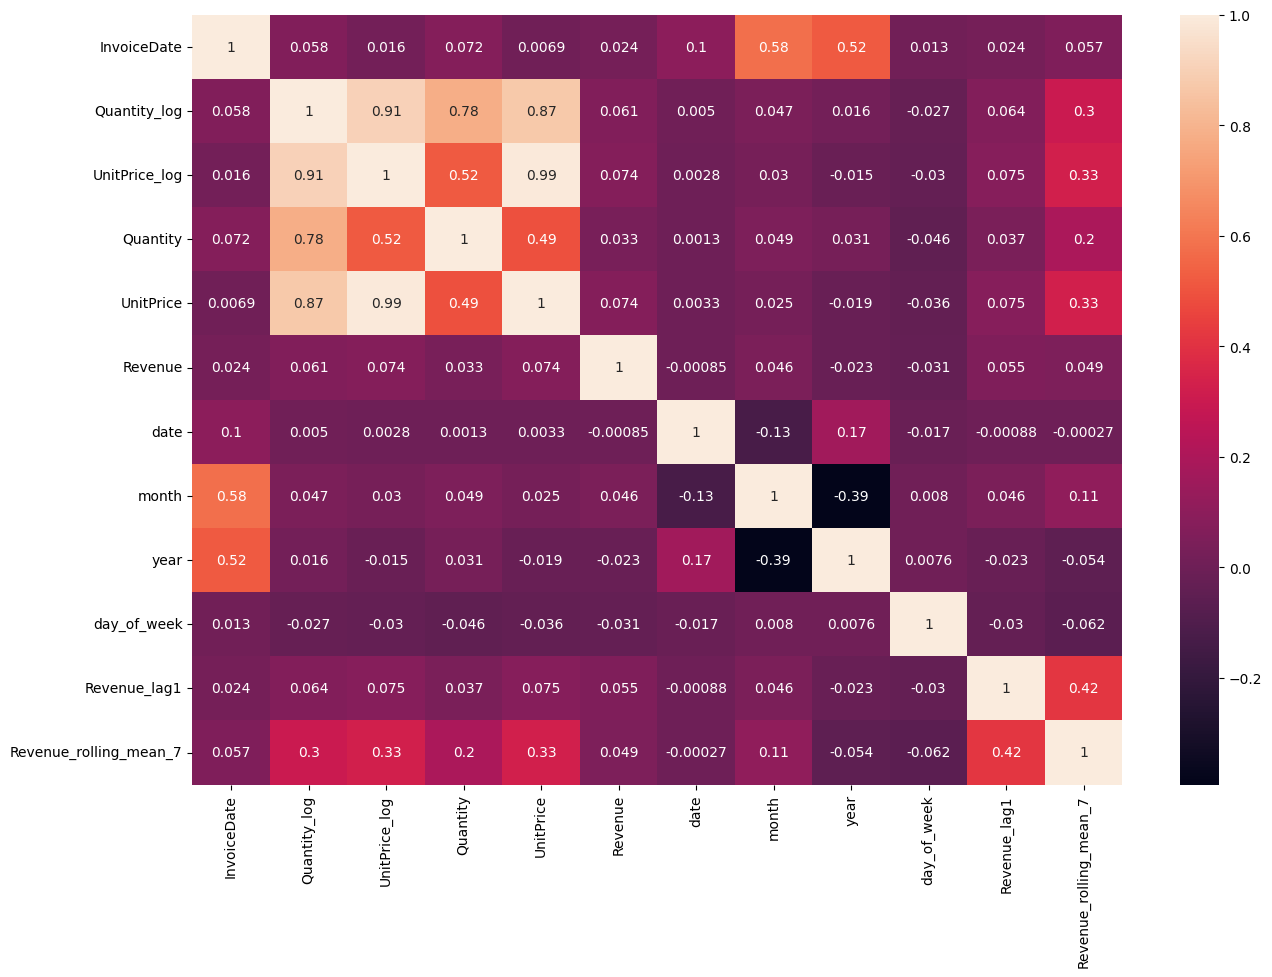

In [76]:
plt.figure(figsize=(15,10))
sns.heatmap(sales_forcasting.corr(),annot=True)

In [60]:
sales_forcasting.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16334 entries, 6 to 16339
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   InvoiceDate             16334 non-null  datetime64[ns]
 1   Quantity_log            16334 non-null  float64       
 2   UnitPrice_log           16334 non-null  float64       
 3   Revenue_log             16334 non-null  float64       
 4   date                    16334 non-null  int32         
 5   month                   16334 non-null  int32         
 6   year                    16334 non-null  int32         
 7   day_of_week             16334 non-null  int32         
 8   Revenue_lag1            16334 non-null  float64       
 9   Revenue_rolling_mean_7  16334 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int32(4)
memory usage: 1.1 MB


,date,month,year,day_of_week
6,1,12,2010,2
7,1,12,2010,2
8,1,12,2010,2
9,1,12,2010,2
10,1,12,2010,2
...,...,...,...,...
16335,9,12,2011,4
16336,9,12,2011,4
16337,9,12,2011,4
16338,9,12,2011,4


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Features and target variable
X = sales_forcasting[["Quantity","date","month","day_of_week","Revenue_lag1","Revenue_rolling_mean_7"]]
y = sales_forcasting['Revenue']
scaler = StandardScaler()

# Fit the scaler on the training data and transform the features
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
model = RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

RMSE: 574432.5571241168


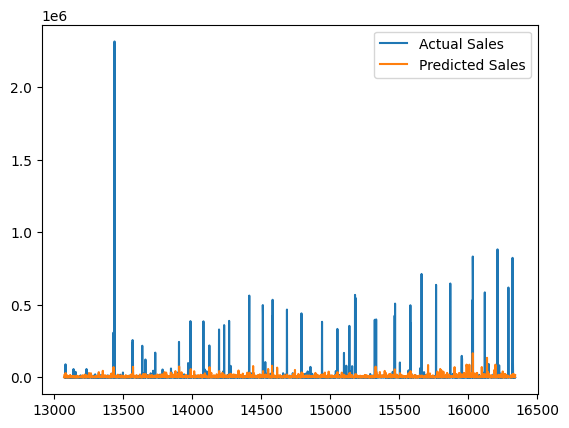

In [56]:
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, predictions, label='Predicted Sales')
plt.legend()
plt.show()


In [50]:
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance}')
    

day_of_week: 0.04489443217836744
year: 0.00835215912287249
Revenue_rolling_mean_7: 0.9467534086987601


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# Features and target variable
X = sales_forcasting[['day_of_week','year','Revenue_rolling_mean_7']]
y = sales_forcasting['Revenue_log']
scaler = StandardScaler()

# Fit the scaler on the training data and transform the features
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_predictions = gb_model.predict(X_test)

# Calculate RMSE
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
print(f"Gradient Boosting RMSE: {gb_rmse}")


Gradient Boosting RMSE: 69647.36707722518


In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471726 entries, 0 to 471725
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceNo      471726 non-null  int32  
 1   StockCode      471726 non-null  object 
 2   Description    471726 non-null  object 
 3   Quantity       471726 non-null  int16  
 4   InvoiceDate    471726 non-null  object 
 5   UnitPrice      471726 non-null  float16
 6   CustomerID     471726 non-null  int16  
 7   Country        471726 non-null  object 
 8   UnitPrice_log  471726 non-null  float64
 9   Quantity_log   471726 non-null  float64
 10  Revenue        471726 non-null  int16  
 11  Year           471726 non-null  int16  
 12  Month          471726 non-null  int8   
 13  Day            471726 non-null  int8   
 14  day_of_week    471726 non-null  int8   
 15  day_name       471726 non-null  object 
 16  quarter        471726 non-null  int8   
dtypes: float16(1), float64(2), in

# Polynomial Regression

In [7]:
from sklearn.preprocessing import MinMaxScaler
X= raw_df[['CustomerID','Quantity_log', 'UnitPrice_log', 'Day','Month','Year']]
y = raw_df["Revenue"]

MM = MinMaxScaler()
X_scaled = MM.fit_transform(X)


In [8]:
pd.DataFrame(X_scaled,columns=X.columns).head(1)

,CustomerID,Quantity_log,UnitPrice_log,Day,Month,Year
0,0.921119,0.294379,0.441137,0.0,1.0,0.0


In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3,include_bias=False,interaction_only=False)

# Fit and transform the feature set to generate polynomial features
X_poly = poly.fit_transform(X_scaled)


X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred_pr = LR.predict(X_test)

# Predict on the training data
y_train_pred = LR.predict(X_train)

# Print the results

print(f"Training data Set : r2 score = {r2_score(y_train,y_train_pred):.2f} & MSE = {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Testing data Set : r2 score = {r2_score(y_test,y_pred_pr):.2f} & MSE = {mean_squared_error(y_test, y_pred_pr):.2f}")


Training data Set : r2 score = 0.97 & MSE = 24.99
Testing data Set : r2 score = 0.97 & MSE = 22.91


In [10]:
from sklearn.model_selection import cross_validate, cross_val_score

# Perform cross-validation
scores = cross_validate(LR, X_test, y_test, cv=10, scoring=["neg_mean_squared_error", "r2"])

# Calculate and print the mean neg_mean_squared_error and mean R2 score
print(f'Mean neg_mean_squared_error across folds: {-scores["test_neg_mean_squared_error"].mean():.2f}')
print(f'Mean r2 score: {scores["test_r2"].mean():.2f}')

Mean neg_mean_squared_error across folds: 23.31
Mean r2 score: 0.97


In [11]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.140072,0.000000,0.512755,0.233333,1.000000,0.0,0.019620,0.000000,0.071823,0.032684,...,0.012704,0.054444,0.000000,0.233333,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
1,0.149819,0.400588,0.391649,0.233333,0.727273,1.0,0.022446,0.060016,0.058677,0.034958,...,0.012704,0.039596,0.054444,0.123416,0.169697,0.233333,0.384673,0.528926,0.727273,1.0
2,0.553069,0.000000,0.750273,0.533333,1.000000,0.0,0.305885,0.000000,0.414952,0.294970,...,0.151704,0.284444,0.000000,0.533333,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
3,0.890253,0.685629,0.339251,0.466667,0.727273,1.0,0.792550,0.610383,0.302019,0.415451,...,0.101630,0.158384,0.217778,0.246832,0.339394,0.466667,0.384673,0.528926,0.727273,1.0
4,0.759386,0.095278,0.210234,0.266667,1.000000,1.0,0.576668,0.072353,0.159649,0.202503,...,0.018963,0.071111,0.071111,0.266667,0.266667,0.266667,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377375,0.891516,0.294379,0.339251,0.333333,0.636364,1.0,0.794801,0.262444,0.302448,0.297172,...,0.037037,0.070707,0.111111,0.134986,0.212121,0.333333,0.257701,0.404959,0.636364,1.0
377376,0.163718,0.215313,0.570783,0.866667,0.818182,1.0,0.026804,0.035251,0.093448,0.141889,...,0.650963,0.614545,0.751111,0.580165,0.709091,0.866667,0.547708,0.669421,0.818182,1.0
377377,0.969495,0.258156,0.391649,0.300000,0.272727,1.0,0.939920,0.250281,0.379702,0.290848,...,0.027000,0.024545,0.090000,0.022314,0.081818,0.300000,0.020285,0.074380,0.272727,1.0
377378,0.669495,0.095278,0.569427,0.833333,0.272727,1.0,0.448223,0.063788,0.381228,0.557912,...,0.578704,0.189394,0.694444,0.061983,0.227273,0.833333,0.020285,0.074380,0.272727,1.0


In [12]:
from sklearn.linear_model import Ridge

Ridge1 = Ridge(alpha=0.01)  # Adjust alpha as needed
Ridge1.fit(X_train, y_train)

y_pred_r = Ridge1.predict(X_test)

# Predict on the training data
y_train_pred = Ridge1.predict(X_train)

# Print the results
print(f"Training data Set : r2 score = {r2_score(y_train,y_train_pred):.2f} & MSE = {mean_squared_error(y_train, y_train_pred):.2f}")

print(f"Testing data Set : r2 score = {r2_score(y_test,y_pred_r):.2f} & MSE = {mean_squared_error(y_test, y_pred_r):.2f}")


Training data Set : r2 score = 0.97 & MSE = 24.99
Testing data Set : r2 score = 0.97 & MSE = 22.91


In [13]:
scores_Ridge1 = cross_validate(Ridge1, X_test, y_test, cv=10, scoring=["neg_mean_squared_error", "r2"])

# Calculate and print the mean neg_mean_squared_error and mean R2 score
print(f'Mean neg_mean_squared_error across folds: {-scores_Ridge1["test_neg_mean_squared_error"].mean():.2f}')
print(f'Mean r2 score: {scores_Ridge1["test_r2"].mean():.2f}')

Mean neg_mean_squared_error across folds: 23.31
Mean r2 score: 0.97


In [14]:
from sklearn.linear_model import Lasso

# Example of using Ridge regression with polynomial features

Lasso1 = Lasso(alpha=0.01)  # Adjust alpha as needed
Lasso1.fit(X_train, y_train)

y_pred_l = Lasso1.predict(X_test)

# Predict on the training data
y_train_pred = Lasso1.predict(X_train)

# Print the results
print(f"Training data Set : r2 score = {r2_score(y_train,y_train_pred):.2f} & MSE = {mean_squared_error(y_train, y_train_pred):.2f}")

print(f"Testing data Set : r2 score = {r2_score(y_test,y_pred_l):.2f} & MSE = {mean_squared_error(y_test, y_pred_l):.2f}")


Training data Set : r2 score = 0.94 & MSE = 48.33
Testing data Set : r2 score = 0.95 & MSE = 46.93


In [15]:
scores_Lasso1 = cross_validate(Ridge1, X_test, y_test, cv=10, scoring=["neg_mean_squared_error", "r2"])

# Calculate and print the mean neg_mean_squared_error and mean R2 score
print(f'Mean neg_mean_squared_error across folds: {-scores_Lasso1["test_neg_mean_squared_error"].mean():.2f}')
print(f'Mean r2 score: {scores_Lasso1["test_r2"].mean():.2f}')

Mean neg_mean_squared_error across folds: 23.31
Mean r2 score: 0.97


In [16]:
metrices = pd.DataFrame({
            "PR":[0.97,24.96,0.97,22.82,23.19,0.97],
            "Ridge":[0.97,24.96,0.97,22.82,23.20,0.97],
            "Lasso":[0.93,50.12,0.94,48.72,23.20,0.97]
        })
metrices.index=["Training_r2_score","Training_mse","Testing_r2_score","Testing_mse","Cross_val_scores_mse","Cross_val_scores_r2"]
metrices

,PR,Ridge,Lasso
Training_r2_score,0.97,0.97,0.93
Training_mse,24.96,24.96,50.12
Testing_r2_score,0.97,0.97,0.94
Testing_mse,22.82,22.82,48.72
Cross_val_scores_mse,23.19,23.20,23.20
Cross_val_scores_r2,0.97,0.97,0.97


# Decision Tree

In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor(max_depth=15,
                              splitter = "random",
                              min_samples_leaf = 4,
                              min_samples_split = 13,
                              random_state=42)
DT.fit(X_train, y_train)
y_train_pred = DT.predict(X_train)
y_pred_dt = DT.predict(X_test)


In [18]:
print(f"Training data Set : r2 score = {r2_score(y_train,y_train_pred):.2f} & MSE = {mean_squared_error(y_train, y_train_pred):.2f}")

print(f"Testing data Set : r2 score = {r2_score(y_test,y_pred_dt):.2f} & MSE = {mean_squared_error(y_test, y_pred_dt):.2f}")

Training data Set : r2 score = 1.00 & MSE = 3.74
Testing data Set : r2 score = 0.99 & MSE = 6.55


In [19]:
scores_DT = cross_validate(DT, X_test, y_test, cv=10, scoring=["neg_mean_squared_error", "r2"])

# Calculate and print the mean neg_mean_squared_error and mean R2 score
print(f'Mean neg_mean_squared_error across folds: {-scores_DT["test_neg_mean_squared_error"].mean():.2f}')
print(f'Mean r2 score: {scores_DT["test_r2"].mean():.2f}')

Mean neg_mean_squared_error across folds: 25.69
Mean r2 score: 0.97


In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [13, 15, 10],
    'min_samples_split': [13, 15, 100],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best R-squared score: {grid_search.best_score_}')


Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 13}
Best R-squared score: 0.9939248872679295


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Set the maximum depth of each tree
rf = RandomForestRegressor(
                            n_estimators=100,
                            max_depth=10,
                            min_samples_split=10,
                            min_samples_leaf=5,
                            max_features='sqrt'
)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_train_pred = rf.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)

print(f"R² score = {r2:.3f} & MSE = {mse:.3f}")


R² score = 0.961 & MSE = 30.923


In [22]:
from sklearn.model_selection import cross_validate
scores = cross_validate(rf, X, y, cv=10, scoring=['r2', 'neg_mean_squared_error'])

# Extract and print the results
mean_r2 = scores['test_r2'].mean()
mean_mse = -scores['test_neg_mean_squared_error'].mean()
mean_r2,mean_mse

(0.9477362152383245, 42.790161820631326)

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
    n_estimators=200,          # Number of boosting stages
    learning_rate=0.05,        # Learning rate
    max_depth=3,               # Depth of each tree
    subsample=0.8,             # Fraction of samples used for training each tree
    min_samples_leaf=4,        # Minimum samples per leaf
    max_features='sqrt'        # Number of features considered for best split
)
gb.fit(X_train, y_train)

# Predict and evaluate the model
y_train_pred = gb.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)

print(f"R² score = {r2:.3f} & MSE = {mse:.3f}")


R² score = 0.947 & MSE = 42.219


In [24]:
from sklearn.model_selection import cross_validate
scores = cross_validate(gb, X, y, cv=10, scoring=['r2', 'neg_mean_squared_error'])

# Extract and print the results
mean_r2 = scores['test_r2'].mean()
mean_mse = -scores['test_neg_mean_squared_error'].mean()
mean_r2,mean_mse

(0.94997952167561, 41.11998356732412)

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ft', FunctionTransformer(np.log1p), ['Quantity_log', 'UnitPrice_log'])  # Apply log transform
    ],
    remainder='passthrough'  # Keep other columns as they are
)

In [39]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),                     # Preprocess selected features
    ('scaler', MinMaxScaler()),                         # Scale features
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt'
    ))  # Random Forest model
])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

In [ ]:
pd.DataFrame(X)

In [42]:
import pickle
pickle.dump(X,open("X.pkl","wb"))
pickle.dump(pipeline,open("pipeline.pkl","wb"))